# Modelling - RAPP

## 1. Context

Rotterdam Accommodation Price Predictor (RAPP) is a machine learning project aimed at predicting the accommodation price in Rotterdam for seekers, especially the Vietnamese community in the city. Features to consider will be taken from attributes of the accommodations (e.g. distant to city center) and infrastructure facts (e.g. surface area). Unanchored data for this project has been scraped from [Pararius](https://www.pararius.com/apartments/rotterdam/page-1). The process could be found in a separate notebook - "Data Scraper - RAPP", and the reasoning for choosing the site as source can be found in the proposal. Besides this, the anchoring and data exploration process can be found in the EDA and Provisioning notebook. This document contains the feature selection, modelling, and evaluation of result. 

## 2. Feature selection

Some essential libraries must first be loaded.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
%matplotlib inline

The data created by the EDA and Provisioning process will now be loaded from the local system.

In [2]:
rtd = pd.read_csv(r'C:\Users\pnanp\Desktop\Housing_GC\data.csv', index_col = 0)
rtd.head()

,house_price,rental_agency,postcode,rooms,surface,type,label,distance,zip,yelp_prices,yelp_ratings,num_service,sp_prices,sp_ratings,sp_num
0,3150,Dop & Dop Consultancy,3072ES,5,145,House,Maashavenkade,2.269337,3072,2.058824,3.985294,34.0,2.000000,3.666667,3.0
1,2500,Fransen Vastgoed,3033AB,2,65,Apartment,Walenburgerweg,1.698153,3033,1.800000,3.800000,5.0,3.000000,4.000000,1.0
2,2300,Loftly,3014GJ,2,55,Apartment,Nieuwe Binnenweg,1.341806,3014,1.923077,3.807692,39.0,1.666667,3.666667,9.0
3,2300,Stad en Land Makelaars,3071NR,4,101,Apartment,Maaskade 159 D,0.900334,3071,2.333333,3.833333,6.0,1.500000,4.250000,2.0
4,2500,Stad en Land Makelaars,3065PG,3,110,Apartment,Huub van den Brulestraat 103,5.484532,3065,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [3]:
rtd.shape

(1279, 15)

The dataframe has been named rtd. There are 1279 rows and 15 columns with the following specifications:

* house_price: rental price of accommodation - euros/month (target variable)
* rental_angency
* postcode
* rooms: number of rooms in the accommodation
* surface: the surface area of the accommodation
* type: rental accommodation type 
* label: address by street and number
* distance: km to the selected point in the center (see EDA and Provisioning notebook for specific detail)
* zip: first four digit of postcode - indicate area/neighbourhood
* yelp_prices: average price level of catering/refreshment/hotel services within the area (scale: 1 - cheap, 2 - moderate, 3 - expensive, 4 - very expensive)
* yelp_ratings: average rating of catering/refreshment/hotel services within the area
* num_service: number of services in the area
* sp_prices: average price level of supermarket in the area (scale: 1 - cheap, 2 - moderate, 3 - expensive, 4 - very expensive)
* sp_ratings: average rating of supermarkets in the area
 

As will be shown below, there is no null value within the current dataset.

In [4]:
rtd.isna().sum()

house_price      0
rental_agency    0
postcode         0
rooms            0
surface          0
type             0
label            0
distance         0
zip              0
yelp_prices      0
yelp_ratings     0
num_service      0
sp_prices        0
sp_ratings       0
sp_num           0
dtype: int64

All features are also in the suitable types for their current content.

In [5]:
rtd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 0 to 1278
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_price    1279 non-null   int64  
 1   rental_agency  1279 non-null   object 
 2   postcode       1279 non-null   object 
 3   rooms          1279 non-null   int64  
 4   surface        1279 non-null   int64  
 5   type           1279 non-null   object 
 6   label          1279 non-null   object 
 7   distance       1279 non-null   float64
 8   zip            1279 non-null   int64  
 9   yelp_prices    1279 non-null   float64
 10  yelp_ratings   1279 non-null   float64
 11  num_service    1279 non-null   float64
 12  sp_prices      1279 non-null   float64
 13  sp_ratings     1279 non-null   float64
 14  sp_num         1279 non-null   float64
dtypes: float64(7), int64(4), object(4)
memory usage: 159.9+ KB


Since the variables all have correct datatype, the next step is to look at the correlation between the features and the target variable. This can be done using a heatmap which displays Pearson's correlation coefficient. It is the test statistics that measures the association between two (numerical) variables. From it, information about the magnitude of the relationship and the direction (positive or negative) can be derived.

Because RAPP's aim is to predict the rental price in Rotterdam using infrastructure facts and convenience attributes (more detail in the proposal), the following variables will be put onto the heatmap besides rental price: rooms, surface, distance, yelp_prices, yelp_ratings, num_service, sp_prices, sp_ratings, sp_num. The heat map is as follow:

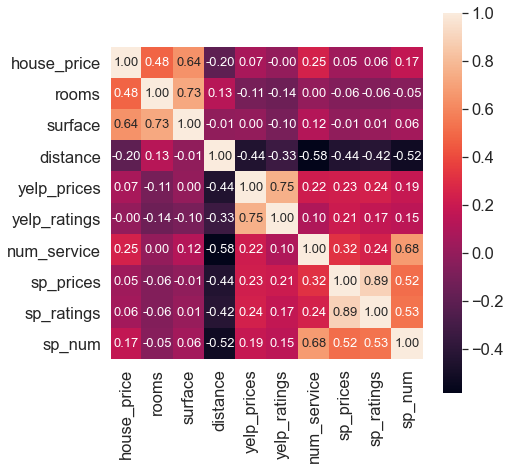

In [6]:
var = ['house_price','rooms', 'surface','distance','yelp_prices',
        'yelp_ratings','num_service','sp_prices','sp_ratings', 
        'sp_num']
cm = np.corrcoef(rtd[var].values, rowvar=0)
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (7,7)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',
                 annot_kws={'size': 13},yticklabels=var,xticklabels=var)
plt.show()

From the heatmap above, some features that have acknowledgeable correlation to the target variable according to Pearson coeficient includes: surface (0.64), rooms (0.48), num_service (0.25), sp_num (0.17), distance (0.2). These 5 features with values above 0.1 will be used for modelling.

## 3. Modelling - Evaluation - Tuning

### 3.1. Random Forest Regressor

To perform predictive analysis on the data thus far, different regression models will be selected. The first is Random Forest - a versatile ensemble technique that can be used for both classification and regression. It has various parameters to aid in tracking and prevention of overfitting. In this case, RAPP will specifically use RF regressor model. The essential working method behind this model is to create different trees with bootstraped samples of the training data, train the model for each sample, then average the predictions to get a final result. The first iteration will be basic (i.e. without parameter tuning). 

For evaluation, R^2 and RMSE will be used. The former measures the proportion of the variance for a dependent variable (y) that can be explained by independent variables (X) in a regression model. As for RMSE (Root Mean Square Error), it signifies the average difference between the observed known values of the outcome and the predicted value by the model (same unit as  the dependant variable). Overall, a high R^2 and low RMSE is desirable.

In [7]:
# getting features and target
rtd_mod = rtd[['house_price','rooms', 'surface','distance','num_service','sp_num']]
# defining feature X, target y, and split into train - test data
y = rtd_mod.house_price
X = rtd_mod.drop('house_price', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)

from sklearn.ensemble import RandomForestRegressor

# fitting
rf = RandomForestRegressor(random_state = 0)
rf.fit(X_train, y_train)
# predicting
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
# get evaluation metrics
print('RMSE --> train: %.3f; test: %.3f' % (sm.mean_squared_error(y_train, y_train_pred, squared=False),
                                       sm.mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 --> train: %.3f; test: %.3f' % (sm.r2_score(y_train, y_train_pred),
                                       sm.r2_score(y_test, y_test_pred)))

RMSE --> train: 284.426; test: 663.690
R^2 --> train: 0.912; test: 0.456


The evaluation measurements for train and test data have been printed above. For train data, 91.2% of the variation in rent price can be explained by the selected features and the RMSE for it is 284.426. As for the test data, only 45.6% of the variation can be explained and the RMSE is 663.690. To further understand the significance of such RMSE values, the price distribution of the accommodations in the data needs to be referenced. It will be plotted below.

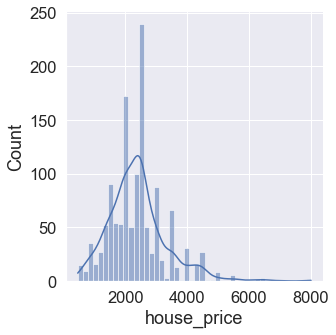

In [8]:
sns.displot(rtd['house_price'], color = 'b', kde = True)

As observable from the rent price distribution graph above, y value can range from a few hundreds to 8000 euros per month. However, there is right-skewness towards the high-end of prices. This means that RMSE of 663.690 euros is significant for the majority of observations. It is likely that the value will be dropped with pruning and better parameters.

One other aspect to consider is the offset between RMSE or R^2 of train and test data. There is a wide gap, indicating overfitting of the model. To validate this and place restriction on the model such that it does not grow too complex and overfit, the relationship between max_depth parameter (longest path between root and leaf node - growth of tree) and RMSE will be plotted and the optimal value will be selected.

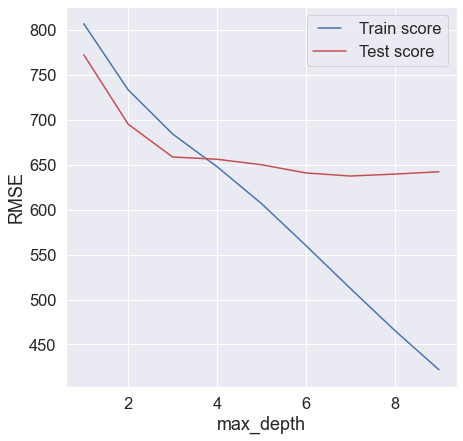

In [9]:
# creating max_depths of 1 to 9 and score lists for later plotting
max_depths = np.linspace(1, 9, 9, endpoint=True)
train_score = []
test_score = []

# loop through max_depths' values to fit and get RMSE  
for max_depth in max_depths:
   rf = RandomForestRegressor(max_depth=max_depth, random_state=0)
   rf.fit(X_train, y_train)
    
   train_pred = rf.predict(X_train)
    
   rmse_train = sm.mean_squared_error(y_train, train_pred, squared=False)
   train_score.append(rmse_train)
    
   test_pred = rf.predict(X_test)

   rmse_test = sm.mean_squared_error(y_test, test_pred, squared=False)
   test_score.append(rmse_test)

# plotting 
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_score, 'b', label='Train score')
line2, = plt.plot(max_depths, test_score, 'r', label='Test score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE')
plt.xlabel('max_depth')
plt.show()

As observable from above, RMSE for train set continuously decrease as the model become more complex. However, after a max_depth of 6, RMSE for test set no longer drop. This means that increasing complexity beyond this point would result in overfitting. The model will now include the optimal max_depth value.

In [10]:
rf = RandomForestRegressor(random_state = 0, max_depth = 6)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('RMSE --> train: %.3f; test: %.3f' % (sm.mean_squared_error(y_train, y_train_pred, squared=False),
                                       sm.mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 --> train: %.3f; test: %.3f' % (sm.r2_score(y_train, y_train_pred),
                                       sm.r2_score(y_test, y_test_pred)))

RMSE --> train: 560.174; test: 640.681
R^2 --> train: 0.660; test: 0.493


Now that the complexity of the model has been restricted, it can be seen that the gap between train and test RMSE has significantly reduced. Beside this, more variation in price of the test set can now be explained by the features (from 45.6% to 49.3%). To reach the best performance for this model, randomized search will be used to tune the parameters.

In [11]:
from sklearn.model_selection import RandomizedSearchCV

param = [
    {'n_estimators':  np.arange(1, 100, 5),
     'max_features': ['auto', 'sqrt', 'log2'],
     'min_samples_split':[2, 5, 10],
     'min_samples_leaf': [1, 2, 4],
     'bootstrap': [True, False],
     'max_depth': [3,4,5,6]}
]

tuning = RandomizedSearchCV(
        RandomForestRegressor(random_state = 0), param, cv=5, n_iter=10, random_state=0
    )
tuning.fit(X_train, y_train)
print(tuning.best_params_)

{'n_estimators': 66, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 6, 'bootstrap': True}


Now that the suitable values for the parameters have been selected, the RF regressor will be re-modeled to include them.

In [12]:
rf = RandomForestRegressor(random_state = 0, max_depth = 6, n_estimators = 66, min_samples_split = 5, 
                          min_samples_leaf = 1, max_features = 'auto', bootstrap = True)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('RMSE --> train: %.3f; test: %.3f' % (sm.mean_squared_error(y_train, y_train_pred, squared=False),
                                       sm.mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 --> train: %.3f; test: %.3f' % (sm.r2_score(y_train, y_train_pred),
                                       sm.r2_score(y_test, y_test_pred)))

RMSE --> train: 568.447; test: 639.331
R^2 --> train: 0.650; test: 0.496


Although the R^2 and RMSE for the test set did not exhibit significant changes, the gap between them and that of the train set has been reduced a little further. The current result shows that 49.6% of the variation in rent price can be explained by the selected features and the RMSE is 639.331 in the test set.

### 3.2. XGBOOST

Extreme Gradient Boosting (XGBoost) is also an ensemble machine learning algorithm that can be used for classification or regression problems. The essential idea to it is learning from past results to enhance predictions. There are three elements to this type of model, including a loss function to be optimized (e.g. squared error for regression), a weak learner to make predictions (short and simple decision trees), and additive modelling to add weak learners that can do what their predeccessors could not. XGBoost is commonly used because of its speed and performance. The first iteration of the XGBoost regressor below will be without tuning of parameters.

In [13]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(random_state = 0)
xgbr.fit(X_train, y_train)

y_train_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)

print('RMSE --> train: %.3f; test: %.3f' % (sm.mean_squared_error(y_train, y_train_pred, squared=False),
                                       sm.mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 --> train: %.3f; test: %.3f' % (sm.r2_score(y_train, y_train_pred),
                                       sm.r2_score(y_test, y_test_pred)))

RMSE --> train: 191.674; test: 695.268
R^2 --> train: 0.960; test: 0.403


C:\Users\pnanp\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


For the test set, R^2 is 0.403 and RMSE is 695.268. This is in contrast to a 0.96 R^2 and only 191.674 RMSE for training set. Hence, heavy overfitting is a clear phenomenon with this baseline model. This has been expected as XGBoost will proceed to add on weak learners until a stopping condition is reached, but there is no parameter for that here. Adding restriction to max_depth and tuning of other parameters are needed to improve the model's quality and deal with overfitting. It is noteworthy that according to the developers, the warning above is an expected issue (https://github.com/dmlc/xgboost/issues/6908). It will be encountered again below and create display difficulties; hence, the warning from this specific module should be ignored.

In [14]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

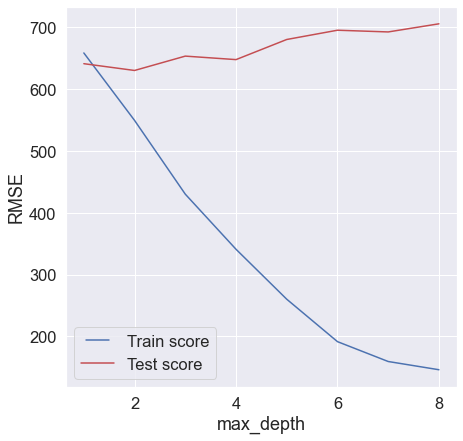

In [15]:
# creating max_depths of 1 to 9 and score lists for later plotting
max_depths = np.arange(1, 9, 1)
train_score = []
test_score = []

# loop through max_depths' values to fit and get RMSE  
for max_depth in max_depths:
   xgbr =  xgb.XGBRegressor(max_depth=max_depth, random_state=0)
   xgbr.fit(X_train, y_train)
    
   train_pred = xgbr.predict(X_train)
    
   rmse_train = sm.mean_squared_error(y_train, train_pred, squared=False)
   train_score.append(rmse_train)
    
   test_pred = xgbr.predict(X_test)

   rmse_test = sm.mean_squared_error(y_test, test_pred, squared=False)
   test_score.append(rmse_test)

# plotting 
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_score, 'b', label='Train score')
line2, = plt.plot(max_depths, test_score, 'r', label='Test score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE')
plt.xlabel('max_depth')
plt.show()


Eventhough RMSE will decrease as max_depth increases, the error measurement would actually increase for test data after the value of 2. Hence, this is the optimal max_depth for the current XGBoost regressor. 

In [16]:
params = {
        'min_child_weight': np.arange(1, 10, 1),
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'eta': np.arange(0, 1, 0.1)
        }

tuning = RandomizedSearchCV(
        xgb.XGBRegressor(random_state = 0), params, cv=5, n_iter=10, random_state=0
    )
tuning.fit(X_train, y_train)
print(tuning.best_params_)

{'subsample': 0.6, 'min_child_weight': 3, 'gamma': 1, 'eta': 0.2, 'colsample_bytree': 0.8}


 Below is the re-modelling of XGBoost regressor with tuned parameters.

In [17]:
xgbr = xgb.XGBRegressor(random_state = 0, subsample = 0.6, min_child_weight = 3, max_depth = 2, 
                        gamma = 1, eta = 0.2, colsample_bytree = 0.8)
xgbr.fit(X_train, y_train)

y_train_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)

print('RMSE --> train: %.3f; test: %.3f' % (sm.mean_squared_error(y_train, y_train_pred, squared=False),
                                       sm.mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 --> train: %.3f; test: %.3f' % (sm.r2_score(y_train, y_train_pred),
                                       sm.r2_score(y_test, y_test_pred)))

RMSE --> train: 593.548; test: 623.834
R^2 --> train: 0.619; test: 0.520


Not only has the gap between RMSE of train and test data been significantly reduced, the measurements for the test set have also improved. The result for this XGBoost regressor indicates that 52% of the variation in price can be explained by the features (within test set) and there is a RMSE of 623.834 (error measurment of the baseline model was 695.268).

### 3.3. SVR

The final model to be tried is support vector regression - SVR. It is based on SVM, but there are a few differences besides just the type of problem to be solved. Firstly, SVR adds a tube around the estimated function (hyperplane), which width is determined by a parameter called ε (epsilon). All points that fall within this tube are considered as correct predictions. Secondly, the support vectors for SVR can also be the points that fall outside the tube rather than just the ones at the margin. The distance to these points is controled by 'slack' or the C parameter in SVR. The first iteration will be without parameter tuning. It is noteworthy that data for SVR needs to be standardized. 

In [18]:
# getting features and target
rtd_mod = rtd[['house_price','rooms', 'surface','distance','num_service','sp_num']]
# defining feature X, target y, standardize and split into train - test data
y = rtd_mod.house_price
X = rtd_mod.drop('house_price', axis = 1)

scale = StandardScaler()
X = scale.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)

from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)

y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

print('RMSE --> train: %.3f; test: %.3f' % (sm.mean_squared_error(y_train, y_train_pred, squared=False),
                                       sm.mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 --> train: %.3f; test: %.3f' % (sm.r2_score(y_train, y_train_pred),
                                       sm.r2_score(y_test, y_test_pred)))

RMSE --> train: 938.922; test: 888.113
R^2 --> train: 0.046; test: 0.027


As observable above, the proportion of variation in price explanable by features did not cross even 5% in either test or train set. Their RMSE are also very severe with respect to the unit and distribution of the rental prices in Rotterdam. However, this may change with proper parameters. Once more, randomized search will be used to find out the suitable parameter values.

In [19]:
params = {'kernel': ('linear', 'rbf','poly', 'sigmoid'), 
 'C':np.arange(1,100,1),
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 'epsilon':[0.1,0.2,0.5,0.3]}

tuning = RandomizedSearchCV(
        SVR(), params, cv=5, n_iter=10, random_state=0
    )
tuning.fit(X_train, y_train)
print(tuning.best_params_)

{'kernel': 'linear', 'gamma': 0.001, 'epsilon': 0.1, 'C': 35}


Below is the re-modelling of SVR based on the parameters provided above.

In [20]:
svr = SVR(kernel = 'linear', gamma = 0.001, epsilon = 0.1, C = 35)
svr.fit(X_train, y_train)

y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

print('RMSE --> train: %.3f; test: %.3f' % (sm.mean_squared_error(y_train, y_train_pred, squared=False),
                                       sm.mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 --> train: %.3f; test: %.3f' % (sm.r2_score(y_train, y_train_pred),
                                       sm.r2_score(y_test, y_test_pred)))

RMSE --> train: 716.010; test: 666.718
R^2 --> train: 0.445; test: 0.451


The result has improved significantly. It can now be seen that up to 45.1% of variation in price can be explained by the features (within testing data). Even though the RMSE of test set is still 666.718, this is a very big improvement if compared to the baseline model. 

Out of all the models above, XGBoost has performed the best with an R^2 of 0.52 and RMSE of 623.834. This means that 52% of variation in rental price of testing data can be explained by the selected features. However, the root mean square error is rather noticeable considering the distribution and unit of the rental prices. Nonetheless, the XGBoost regressor will be the selected model at this stage of RAPP. To get better result would require another loop through stage 2 and 3 of the AI methodology (provisioning and modelling) to improve data quality in terms of more features. Given the time constraint in the proposal, the path ahead will be to report on the findings, prepare demonstration material, and return to stage 2 and 3 at a more available time the future.  